# Week 10 - Embeddings and Graph Convolutions

## Exercise 1: Theoretical questions for Graph Convolutional Networks
1. In Graph Convolutional Networks (GCN), what is the feature/attribute matrix $X$ if the graph has no attributes? 

    You still have the nodes and the structure of the graph.

2. Describe what happens when we add an extra layer to a GCN.

    We add another step of neighbors as nodes.

3. How many layers should a network have in order for any node to receive "messages" from all other nodes? 

    The same amount as in the longest path

4. Why do we most often use $\tilde{\mathbf{A}} = \mathbf{A} + \mathbf{I}$ and not just $\mathbf{A}$ in graph convolutions?

    We get self loops, so they are able to be at your own point.

4. How can we extend GCNs to learn from multiple graphs $G_1$, ..., $G_r$, at the same time? 

    The size of the graph is the largest one. Then we train on each of them. 

## Exercise 2: Falling in love with PyTorch
This exercise is mainly an introduction for those of you who didn't work with PyTorch before (and a recap for the rest of you).

PyTorch is a framework similar to Numpy but with more "muscles." The main reason why we wish to use it here is that it has an efficient implementation of [automatic differentiation](https://en.wikipedia.org/wiki/Automatic_differentiation), i.e., we can define a "forward" computation and PyTorch can compute the gradients for us.

We will practice a bit here by making a tiny Neural Network, which can classify MNIST digits.

However, first we need to install `pytorch` (and `torchvision`). You can either go to your anaconda console (with `dm20` activated) and run

```bash
> conda install -c pytorch pytorch torchvision
> conda install -c conda-forge ipywidgets
```

or you can try to run the following code cell:

In [1]:
import sys
!{sys.executable} -m pip install torch torchvision ipywidgets

     ---------------------------------------- 0.0/138.3 kB ? eta -:--:--
     -------------------------------------- 138.3/138.3 kB 4.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
     ------------ --------------------------- 0.7/2.1 MB 20.2 MB/s eta 0:00:01
     ------------------------------------ --- 1.9/2.1 MB 24.7 MB/s eta 0:00:01
     ---------------------------------------- 2.1/2.1 MB 22.4 MB/s eta 0:00:00
     ---------------------------------------- 0.0/198.2 kB ? eta -:--:--
     ------------------------------------- 198.2/198.2 kB 12.5 MB/s eta 0:00:00


And then all the imports that we will need this week.

In [2]:
import torch
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import networkx as nx
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

PyTorch support computation on GPUs, which is much faster than CPUs.
So if your machine has a GPU available, we will use that.

In [3]:
# If we have a GPU, we can compute things on it to speed things up. 
# It might require some time to get it working. You might also need to update drivers for your GPU
# Hint: On google colab you can change runtime environment to use GPU. If you need to try some deep learning that requires powerful hardware, 
# this can be an excelent place to start.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


> Below, we have implemented a simple Neural Network for MNIST classification. The only purpose of this part is, as mentioned, to remind you how PyTorch works.
> If you are familiar with PyTorch, you can safely skip the remainder of this exercise.

For those of you who are not familiar with pytorch, we recommend that you pay particular attention to (and maybe look up documentation for) the `Net(nn.Module)` class and the internals of the training loop. The rest of the code is mainly boilerplate code. 

We start by loading some data.

In [4]:
batch_size = 32

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='../utilities/data', train=True,  transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='../utilities/data', train=False, transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 20467145.68it/s]


Extracting ../utilities/data\MNIST\raw\train-images-idx3-ubyte.gz to ../utilities/data\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28965971.74it/s]

Extracting ../utilities/data\MNIST\raw\train-labels-idx1-ubyte.gz to ../utilities/data\MNIST\raw




100%|██████████| 1648877/1648877 [00:00<00:00, 11174832.31it/s]


Extracting ../utilities/data\MNIST\raw\t10k-images-idx3-ubyte.gz to ../utilities/data\MNIST\raw



100%|██████████| 4542/4542 [00:00<00:00, 4542329.22it/s]


Extracting ../utilities/data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ../utilities/data\MNIST\raw



We can then build a tiny Neural Network. Note how we only define layers and forward computations of the network and not any gradient computations.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), padding=1)
        self.max_pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3, 3), padding=1)
        self.max_pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32*7*7, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # Convolutions
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool2(x)
        
        x = x.view(-1, 32 * 7 * 7)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        x = F.log_softmax(x, dim=1)
        return x
    
model = Net()
# Move neural network to selected device
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)

In [6]:
def test_model(loader=test_loader, max_items=10000):
    """
        This function just runs over the elements of the `loader`
        and uses the model to do predictions for accuracy estimates.
    """
    with torch.no_grad(): # We don't need gradients for this
        correct = 0
        total = 0
        for images, labels in loader:
            images       = images.to(device)
            labels       = labels.to(device)
            outputs      = model(images)
            _, predicted = torch.max(outputs, 1)
            total       += labels.size(0)
            correct     += (predicted == labels).sum().item()
            
            if total > max_items: break

        return 100. * correct /  total

Finally, we can define a training loop, which will do gradient descent as we are used to but automatic.
For this, we need to define an optimizer (the gradient descent functionality) and we need to define a loss function (cross-entropy for class prediction).

In [7]:
# Define optimizer (Adam og Stochastic Gradient Descent) and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Adam works way better than SGD for this particular exmaple.
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

# The actual training loop
epochs     = 3
total_step = len(train_loader)

for e in range(epochs): # three epochs
    print ('\rEpoch [%2d/%d] accuracy - train: %.4f \t test: %.4f' % (e, epochs, test_model(train_loader), test_model(test_loader)))
    
    # Test the model performance on the test set
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss    = loss_function(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad() # Remove gradients from last iteration
        loss.backward()       # Compute new gradients
        optimizer.step()      # Tune parameters from gradients

        if (i+1) % 10 == 0:
            print ('\rEpoch [%2d/%d], Step [%3d/%d], Loss: %.4f' % (e+1, epochs, i+1, total_step, loss.item()), end="")
    print()

print ('\rEpoch [%2d/%d] accuracy - train: %.4f \t test: %.4f' % (epochs, epochs, test_model(train_loader), test_model(test_loader)))

Epoch [ 0/3] accuracy - train: 10.0140 	 test: 9.7500
Epoch [ 1/3], Step [1870/1875], Loss: 0.0144
Epoch [ 1/3] accuracy - train: 97.3542 	 test: 97.5600
Epoch [ 2/3], Step [1870/1875], Loss: 0.1056
Epoch [ 2/3] accuracy - train: 98.5024 	 test: 98.5400
Epoch [ 3/3], Step [1870/1875], Loss: 0.0999
Epoch [ 3/3] accuracy - train: 98.6422 	 test: 98.5900


In [8]:
print( torch.cuda.is_available() )

False


Having gone through the code, it should be obvious that PyTorch is a very powerful tool if you want to
train a model with gradient descent. You basically need to do the following steps and then you are good
to go. 

1. Define your model (subclass `torch.nn.Module`) and the associated forward pass (`def forward(...)`)
2. Define your loss (which is differentiable)
3. Compute the loss for your data: `loss = loss_fn(y, model(x))`
4. Compute gradients and optimize parameters: 
```python
optimizer.zero_grad()
loss.backward()
optimizer.step()
```


# Exercise 3 - Programming a Graph Convolutional Network

Now that we know how PyTorch works, we can utilize it to make a Graph Convolutional Network (GCN).

In the following, we will i) define a GCN layer in PyTorch ii) Compose a two-layer GCN and iii) Train the network in a supervised fashion using cross-entropy and only two labeled nodes.

The setup is the following. We will define a single layer of the GCN as follows:
$$
\begin{align}
    \tilde{\mathbf{A}}&= \mathbf{A} + \mathbf{I}\\
    \mathbf{D}_{i i}&=\sum_{j} \tilde{\mathbf{A}}_{i, j} \\
    \mathbf{L} &= \mathbf{D}^{-\frac{1}{2}} \tilde{\mathbf{A}} \mathbf{D}^{-\frac{1}{2}} \\
    \mathbf{H}^0 &= \mathbf{X}\\
    \mathbf{H}^{(k+1)} &=\sigma\left(\mathbf{L} \mathbf{H}^{(k)} \mathbf{W}^{(k)} + \mathbf{b}^{(k)}\right)
\end{align}
$$

We can utilize the linear layer `torch.nn.Linear` to make these layers - but how?
Below you need to fill in what should happen for a GCN layer.
Hint: try to use the `nn.Linear` as a part of your implementation of the GCN layer below.

In [143]:
# Define just one GCN layer
class GCNLayer(nn.Module):
    def __init__(self, L, input_features, output_features, activation=F.relu):
        """
            Inputs:
                L:               The "Laplacian" of the graph, as defined above
                input_features:  The size of the input embedding
                output_features: The size of the output embedding 
                activation:      Activation function sigma
        """
        super().__init__()
        ### TODO Your code here
        self.fc1 = nn.Linear(input_features, output_features)
        self.L = L
        if activation is not None:
            self.activation = activation
        else:
            self.activation = nn.Softmax(dim=1)
        ### TODO Your code here
     
    def forward(self, X):
        ### TODO Your code here
        X = self.L @ X
        X = self.fc1(X)
        X = self.activation(X)
        ### TODO Your code here
        return X

Having defined a graph convolutinal layer, we can now stack a couple of them to get a GCN.
But first, we will need two other ingredients: :
1. Implement the computation of the graph Laplacian for our favorite graph. Surprise, surprise - the karate club graph.
2. Construct the input feature vectors $X \in \mathbb{R}^{n \times n}$.  
    _Hint_: The karate club graph only have one attribute, which is the one we are going to predict, i.e., no features left as input.

In [210]:
# Adjacency matrix
G     = nx.karate_club_graph()
A     = np.array(nx.adjacency_matrix(G, weight=None).todense())
I     = np.eye(A.shape[0])
A     = A + I # Add self loop

### TODO your code here
# Degree matrix
# Normalized Laplacian
# Create input vectors
### TODO your code here
X = I
D = np.diag(np.sum(A, axis=1))
D_inv = np.linalg.inv(np.sqrt(D))
L = D_inv @ A @ D_inv

X = torch.tensor(X, dtype=torch.float, requires_grad=True) # Indicate to pytorch that we need gradients for this variable
L = torch.tensor(L, dtype=torch.float)  # We don't need to learn this so no grad required.

The nodes of the Karate Club graph has one label, namely the club association of each node (member).
If you want a bit more detail: 

> A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.  
> Cite: [Wikipedia](https://en.wikipedia.org/wiki/Zachary%27s_karate_club#Network_description)

Below, we split the nodes into "Mr. Hi" nodes and the rest and treat these as labels for a supervised learning setting.

In [211]:
# Create ground-truth labels
labels = [(0 if d['club']=='Mr. Hi' else 1) for i,d in G.nodes().data()]
labels = torch.tensor(labels, dtype=torch.float)
y      = labels.to(device)
y = y.type(torch.LongTensor)
# Constants used for training in a bit. 
# We are actually only going to use Mr. Hi and the admin for training.
ID_INSTR = 0                                       # The Mr. Hi node
ID_ADMIN = 33                                      # The Admin  node
ID_MEMBERS = set(G.nodes()) - {ID_ADMIN, ID_INSTR} # The rest
labels[ID_ADMIN] = 0.75
labels[ID_INSTR] = 0.25

Then we can finally define our GCN:

In [212]:
# Define convolutional network
in_features, out_features = X.shape[1], 2 # two output features
hidden_dim = 10

# Stack two GCN layers as our model
# nn.Sequential is an implicit nn.Module, which uses the layers in given order as the forward pass
gcn = nn.Sequential(
    GCNLayer(L, in_features, hidden_dim),
    GCNLayer(L, hidden_dim, out_features),
    nn.LogSoftmax(dim=1)
)
gcn.to(device)

Sequential(
  (0): GCNLayer(
    (fc1): Linear(in_features=34, out_features=10, bias=True)
  )
  (1): GCNLayer(
    (fc1): Linear(in_features=10, out_features=2, bias=True)
  )
  (2): LogSoftmax(dim=1)
)

We can now train our model. We are going to train on only the Mr. Hi and the Admin nodes.
The rest of the nodes are going to be left for evaluation.

In [148]:
def train_node_classifier(model, optimizer, X, y, epochs=60, print_every=10):
    for epoch in range(epochs+1):
        y_pred = model(X)

        # Semi-supervised: only use labels of the Instructor and Admin nodes
        labelled_idx = [ID_ADMIN, ID_INSTR]
        loss = F.nll_loss(y_pred[labelled_idx], y[labelled_idx])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % print_every == 0:
            print(f'Epoch {epoch:2d}, loss={loss.item():.5f}')

optimizer = torch.optim.Adam(gcn.parameters(), lr=0.01)
train_node_classifier(gcn, optimizer, X, y)

Epoch  0, loss=0.69585
Epoch 10, loss=0.64836
Epoch 20, loss=0.59168
Epoch 30, loss=0.51246
Epoch 40, loss=0.44035
Epoch 50, loss=0.39299
Epoch 60, loss=0.37292


Having trained the network. Let's do a quick evaluation of it:

In [149]:
from sklearn.metrics import classification_report

y_pred = torch.argmax(gcn(X), dim=1).numpy()
print(classification_report(y.numpy(), y_pred, target_names=['I','A']))


              precision    recall  f1-score   support

           I       1.00      0.59      0.74        17
           A       0.71      1.00      0.83        17

    accuracy                           0.79        34
   macro avg       0.85      0.79      0.79        34
weighted avg       0.85      0.79      0.79        34



Below we remove the top most Softmax layer and plot the learned embeddings.

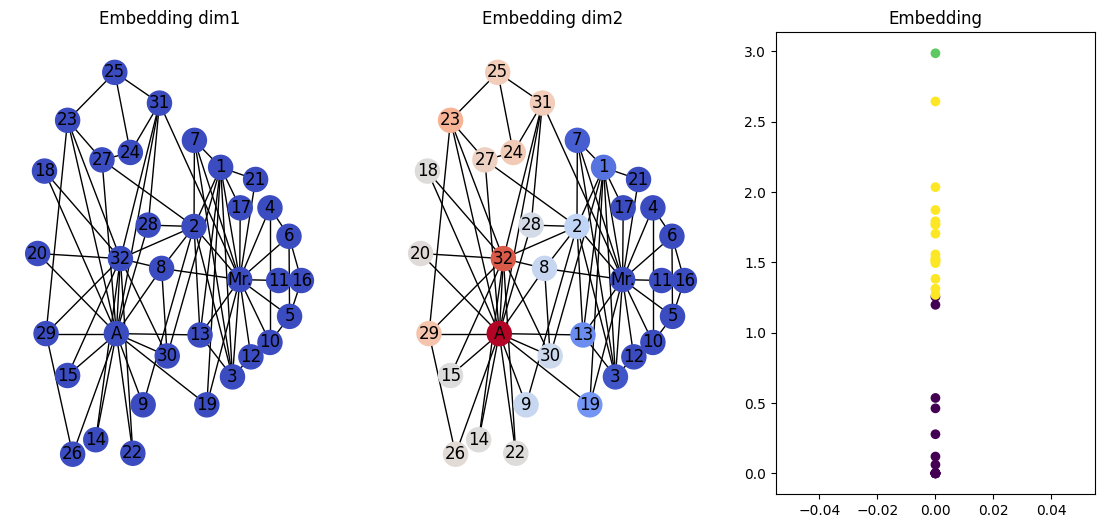

In [150]:
def plot_karate(G, pr=[], ax=None, cmap=plt.get_cmap('RdYlBu'), **kwargs): 
    fixed_positions = {0:(10.74,4.07),1:(9.76,6.48),2:(8.39,5.21),3:(10.37,1.98),4:(12.30,5.61),5:(13.31,3.28),6:(13.28,5.00),7:(8.41,7.06),8:(6.72,4.31),9:(5.77,1.38),10:(12.30,2.72),11:(12.75,4.05),12:(11.32,2.41),13:(8.70,2.88),14:(3.33,0.63),15:(1.88,2.01),16:(13.92,4.05),17:(10.77,5.61),18:(0.69,6.40),19:(9.05,1.38),20:(0.34,4.63),21:(11.56,6.22),22:(5.24,0.34),23:(1.88,7.49),24:(5.11,6.80),25:(4.31,8.52),26:(2.14,0.32),27:(3.65,6.64),28:(6.03,5.24),29:(0.77,2.91),30:(7.01,2.43),31:(6.61,7.86),32:(4.60,4.52),33:(4.39,2.91)}
    if len(pr) :
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax, cmap=cmap, node_color=pr, **kwargs)
    else : 
        nx.draw(G, with_labels=True, pos=fixed_positions, ax=ax, **kwargs)

# Visualize the Karate Club graph
fig, ax = plt.subplots(1,3, figsize=(14,6))
gcn_no_softmax = torch.nn.Sequential(*(list(gcn.children())[:-1])) # Remove the softmax for better plotting
node_colors = gcn_no_softmax(X).detach().cpu().numpy()

node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','Mr.'])})
ax[0].set_title("Embedding dim1")
plot_karate(G, node_colors[:,0], ax=ax[0], cmap=plt.get_cmap('coolwarm'), labels=node_labels)
ax[1].set_title("Embedding dim2")
plot_karate(G, node_colors[:,1], ax=ax[1], cmap=plt.get_cmap('coolwarm'), labels=node_labels)
ax[2].set_title("Embedding")
# nx.draw(G, pos=node_colors, ax=ax[2], node_color=labels, cmap=plt.get_cmap('coolwarm'), node_size=100)
ax[2].scatter(node_colors[:,0], node_colors[:,1], c=labels)


We could try to learn a similar embedding with a standard Neural Network and the same input. This is done in the optional exercises. 

## Exercise 4

In the previous exercise, we learned the parameters of our Neural Network in a supervised setting (we used cross-entropy).
This course is, however, more about unsupervised methods. 
Let's try to get rid of the labels: 

1. Make a new GCN, and train it in an unsupervised manner. You can use a setup similar to last week, i.e., Minimize $\|ZZ^T - S\|^2_F$, where $Z = GCN(X)$ and $S$ is some similarity matrix.
2. Plot the embeddings


In [213]:
### YOUR CODE HERE
# 1. Definde your model
# gcn2 = ...
# Stack two GCN layers as our model

# 2. Compute some similarity matrix
# S = ...
def pagerank_matrix(G, alpha = 0.85) :     
    
    #P = ...
    pagerank_matrix = np.array(list(nx.pagerank(G, alpha=alpha).items()))
    P = torch.tensor(pagerank_matrix, dtype=torch.float32)
    return P

pagerank_tensor = pagerank_matrix(G).clone().detach().requires_grad_(True)
Pr = pagerank_tensor.to(device)
### YOUR CODE HERE
gcn2 = nn.Sequential(
    GCNLayer(L, in_features, hidden_dim),
    GCNLayer(L, hidden_dim, out_features),
    nn.LogSoftmax(dim=1)
)
S = Pr

gcn2 = gcn2.to(device)
S    = S.clone().detach().to(device)

optimizer = torch.optim.Adam(gcn2.parameters(), lr=0.01)
epochs = 200

for e in range(epochs):
    ### YOUR CODE HERE
    #out   = gcn2(X)
    #sim   = ...
    #loss  = ...
    ### YOUR CODE HERE
    out   = gcn2(X)
    # compute similarity matrix
    sim  = torch.mm(out, S.T)
    loss = F.nll_loss(sim, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if e % 40 == 0:
        print(f'Epoch {e:2d}, loss={loss.item():.5f}')

print(f'Epoch {e:2d}, loss={loss.item():.5f}')

Epoch  0, loss=0.39096
Epoch 40, loss=0.20917
Epoch 80, loss=0.15402
Epoch 120, loss=0.15073
Epoch 160, loss=0.14868
Epoch 199, loss=0.14726


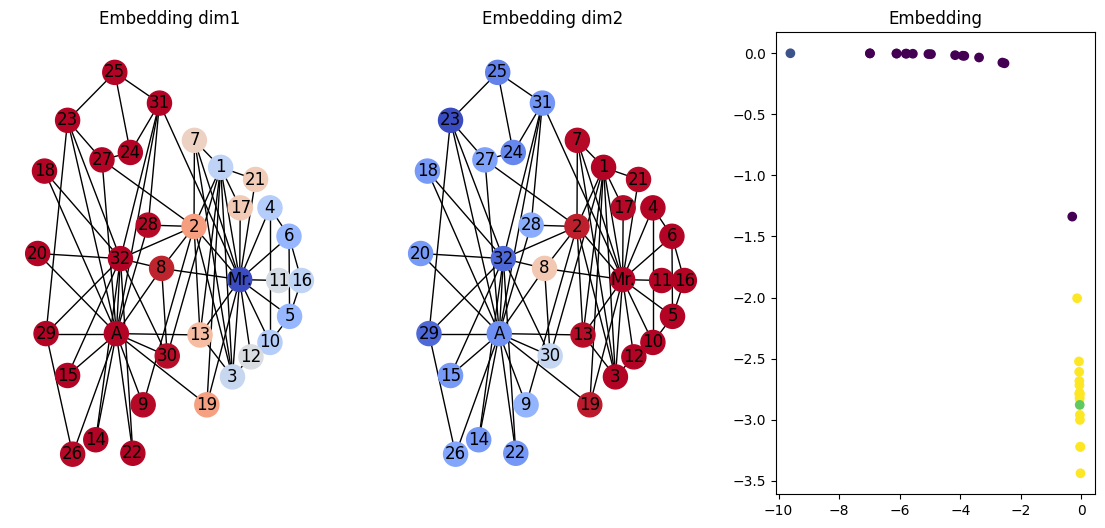

In [188]:
# Visualize the Karate Club graph
fig, ax = plt.subplots(1,3, figsize=(14,6))
node_colors = gcn2(X).detach().cpu().numpy()

node_labels = {i: i for i in ID_MEMBERS}
node_labels.update({i: l for i,l in zip([ID_ADMIN, ID_INSTR],['A','Mr.'])})
ax[0].set_title("Embedding dim1")
plot_karate(G, node_colors[:,0], ax=ax[0], cmap=plt.get_cmap('coolwarm'), labels=node_labels)
ax[1].set_title("Embedding dim2")
plot_karate(G, node_colors[:,1], ax=ax[1], cmap=plt.get_cmap('coolwarm'), labels=node_labels)
ax[2].set_title("Embedding")
# nx.draw(G, pos=node_colors, ax=ax[2], node_color=labels, cmap=plt.get_cmap('coolwarm'), node_size=100)
ax[2].scatter(node_colors[:,0], node_colors[:,1], c=labels)


## Exercise 5: "Deriving" NetMF Algorithms
In class, we saw (on a high level) that DeepWalk asymptoticaly (and implicitly) corresponds to factorizing the matrix 

$$
S = \log \left(\frac{\operatorname{vol}(G)}{b}\left(\frac{1}{T} \sum_{r=1}^{T}\left(D^{-1} A\right)^{r}\right) D^{-1}\right), \qquad \qquad (1)
$$

when the lenght of the random walks tends to infinity. Note that $S$ is symmetric and so the SVD of $S$ will be
$$
   S = U \Sigma U^T
$$
due to [this](https://en.wikipedia.org/wiki/Singular_value_decomposition#Relation_to_eigenvalue_decomposition) relationship.
So now we could do the best linear rank $d$ approximation of $S$ by the SVD if we wanted to - remember result from last week.

We could use this knowledge to do the factorization directly, i.e., compute $S$ from Equation (1) and then use SVD to factorize it.
This is going to be our first step before analyzing Equation in more detail.

1. Implement the matrix factorization as follows:
    1. Compute $M = \frac{vol(G)}{bT}\left(\sum_{r=1}^T (D^{-1}A)^r\right) D^{-1}$ 
    2. Compute $M' = \log( \operatorname{max}(M, 1))$
    3. Decompose $M'$ with the SVD: $M' = U \Sigma V^T$
    4. Compute embedding $Z = U_d \sqrt{\Sigma_d}$

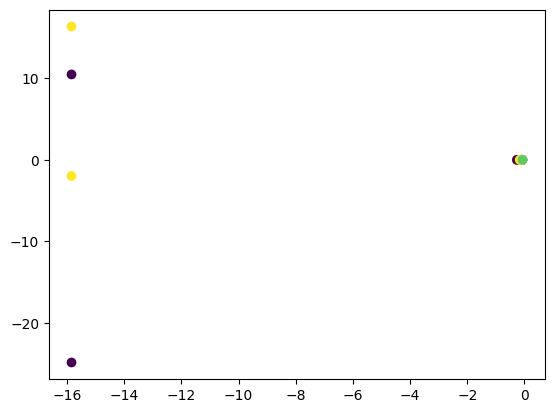

In [223]:
G = nx.karate_club_graph()
A = np.array(nx.adjacency_matrix(G).todense())
vol_G  = G.number_of_edges()
b = 3
T = 10

### TODO Your code here
D = np.diag(np.sum(A, axis=0))
D_inv = np.linalg.inv(D)
M = vol_G / (b * T) * (np.array([np.power((D_inv * A), r) for r in range(T)]).sum()) * D_inv
M_ = np.array([[max(m, 1) for m in mi] for mi in M])
U, s, V = np.linalg.svd(M_)
Z = U @ np.sqrt(np.diag(s))

### TODO Your code here

Z = Z[:, :2] # Use only the two-dimensional embeddings

fig, ax = plt.subplots(1, 1)
ax.scatter(*(Z.T), c=labels)
###

That is great! Now we have yet another graph embedding technique - which is heavily based on theory. 
We will discover a bit more of the theory here.

2. Consider an undirected (weighted) connected graph. Prove that $D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ is symmetric and has eigenvalues in the range $[-1, 1]$.  
    _Hint:_ Recall that the normalized Laplacian $\mathcal{L} = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ has eigenvalues in the range $[0, 2]$.

3. Using the fact that $D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ is symmetric and thus has an eigendecomposition $D^{-\frac{1}{2}} A D^{-\frac{1}{2}} = U \Lambda U^T$, prove that 

$$
\left( \frac{1}{T} \sum_{r=1}^{T}\left(D^{-1} A\right)^{r}\right) D^{-1} = D^{-\frac{1}{2}} U\left( \underbrace{\frac{1}{T} \sum_{r=1}^T \Lambda^r}_{\text{polynomial}} \right) U^T D^{-\frac{1}{2}} \qquad \qquad (2)
$$

4. We have noted that the inner sum is a polynomial on the eigenvalues. As we have realized, the eigenvalues range from $-1$ to $1$. Let's see how these polynomials behave. Plot the function $f(\lambda) = \frac{1}{T} \sum_{r=1}^T \lambda^r$ for different values of $T$. What do you observe, as $T$ increases?  
    _Hint_: What happens to $\lambda$s with negative and smaller values?

In [ ]:
xs = np.linspace(-1, 1, 20)

fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Eigenvalue $\lambda_i$ (before filtering)")
ax.set_ylabel("Eigenvalue $\lambda_i$ (after filtering)")
ax.set_title("$f(\lambda_i) = \\frac{1}{T}\sum_{r=1}^T \lambda^r$")
for T in [1, 2, 5, 10]:
    ### TODO Your code here
    def f(l):
        new_l = ...
        return new_l / T
    y = f(xs)
    ### TODO Your code here
    
    ax.plot(xs, y, label="T: %d" % T)
ax.legend() 

5. Keeping your observation from (4) in mind and say that we knew the eigendecomposition of $D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$ mentioned above. How could we then change the algorithm for computing Equation from (1) to be faster at the cost of approximating $S$? 

# Optionals
## Exercise 6
Let's try to do as in Exercise 3 - but with a standard Neural Network.
That is: 
1. Define a two layer neural network, which takes as input size $n$ vectors and outputs two-dimensional predictions (with softmax).
2. Train it on the two points with labels.
3. Test it on the rest of the points.


In [ ]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=10):
        super().__init__()
        ### TODO code here
        ### TODO code here
    
    def forward(self, X):
        ### TODO code here
        ### TODO code here
        return F.log_softmax(X, 1)

G = nx.karate_club_graph()
simple_net = Net(G.order(), 2, 10).to(device)

In [ ]:
optimizer = torch.optim.Adam(simple_net.parameters(), lr=0.01)
train_node_classifier(simple_net, optimizer, X, labels)

y_pred = torch.argmax(simple_net(X), dim=1).numpy()
y = labels.numpy()

print("Confusion matrix:")
print(classification_report(y, y_pred, target_names=['I','A']))

1. Why is the score here basically the same as random guessing?
2. Why was this not the case in Exercise 3?